In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function


from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import tensorflow as tf

/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [3]:
np.random.seed(142610)

X = np.arange(-3, 3, 0.1)
Y = np.arange(-3, 3, 0.1)
N = len(X)
X, Y = np.meshgrid(X, Y)

ss = 5

Xmod = np.arange(-3, 3, 0.1/ss)
M = len(Xmod)
Ymod = np.arange(-3, 3, 0.1/ss)

Xmod, Ymod = np.meshgrid(Xmod, Ymod)

print(np.shape(X), np.shape(Xmod))

Resp = np.random.normal(1.0, 0.02, np.shape(Xmod))
Resp[150:160,157:162] *= 0.5


(60, 60) (300, 300)


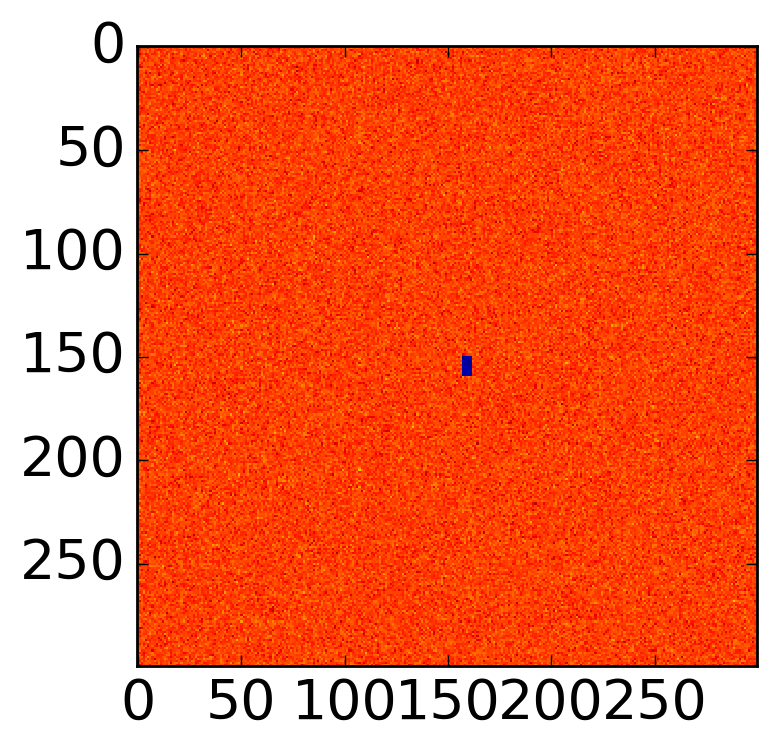

In [4]:
plt.imshow(Resp, interpolation='nearest')

In [5]:
mu = 1.0
sigma_x = 0.35
sigma_y = 0.2

nframes= 65



pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

xpos = np.zeros(nframes)+np.random.normal(0, 0.1, nframes)
ypos = np.zeros(nframes)+np.random.normal(0, 0.1, nframes)

# with apologies to the Python gods for what I'm about to do
fluxval = np.array([0.9999999999980113, 0.9999999999945702, 0.999999999985215, 0.9999999999597857, 0.9999999998906612, 0.9999999997027632, 0.9999999991920029, 0.9999999978036155, 0.9999999940296089, 0.9999999837709397, 0.9999999558860818, 0.9999998800952664, 0.9999996741342091, 0.9999991147150403, 0.9999975973072363, 0.9999934964353527, 0.9999825224734992, 0.9999539154186793, 0.9998841683582055, 0.9997386647420853, 0.9995141409302988, 0.9992896171206892, 0.9991441135134577, 0.9990743664782427, 0.9990457594924832, 0.999034785718504, 0.9990306853573729, 0.999029169337952, 0.9990286136927911, 0.999028417990402, 0.9990283700844442, 0.999028417990402, 0.9990286136927911, 0.999029169337952, 0.9990306853573729, 0.999034785718504, 0.9990457594924832, 0.9990743664782427, 0.9991441135134577, 0.9992896171206892, 0.9995141409302988, 0.9997386647420841, 0.9998841683582055, 0.9999539154186793, 0.9999825224734992, 0.9999934964353527, 0.9999975973072363, 0.9999991147150403, 0.9999996741342091, 0.9999998800952664, 0.9999999558860818, 0.9999999837709397, 0.9999999940296089, 0.9999999978036155, 0.9999999991920029, 0.9999999997027632, 0.9999999998906612, 0.9999999999597857, 0.999999999985215, 0.9999999999945702, 0.9999999999980113, 0.9999999999992774, 0.9999999999997429, 0.9999999999999144, 0.999999999999978])

In [6]:
Z_first = np.zeros((nframes, M, M))
Z = np.zeros((nframes, N,N))
for i in range(nframes):
    Z_first[i] = 12*fluxval[i]*(1/(2*np.pi*sigma_x*sigma_y) * np.exp(-((Xmod-xpos[i])**2/(2*sigma_x**2)
         + (Ymod-ypos[i])**2/(2*sigma_y**2))))
    
    Z_first[i] *= Resp
    
    tmp = np.reshape(Z_first[i], (N, ss, N, ss))
    Z[i] = np.sum(tmp, axis=(1, 3))/ss/ss
    


In [7]:
#Z = 200*multivariate_gaussian(pos, mu, Sigma) 
Zerr = 0.002*np.sqrt(Z)+0.000002
Z += np.random.normal(0, 0.002, (nframes, N,N))*np.sqrt(Z)


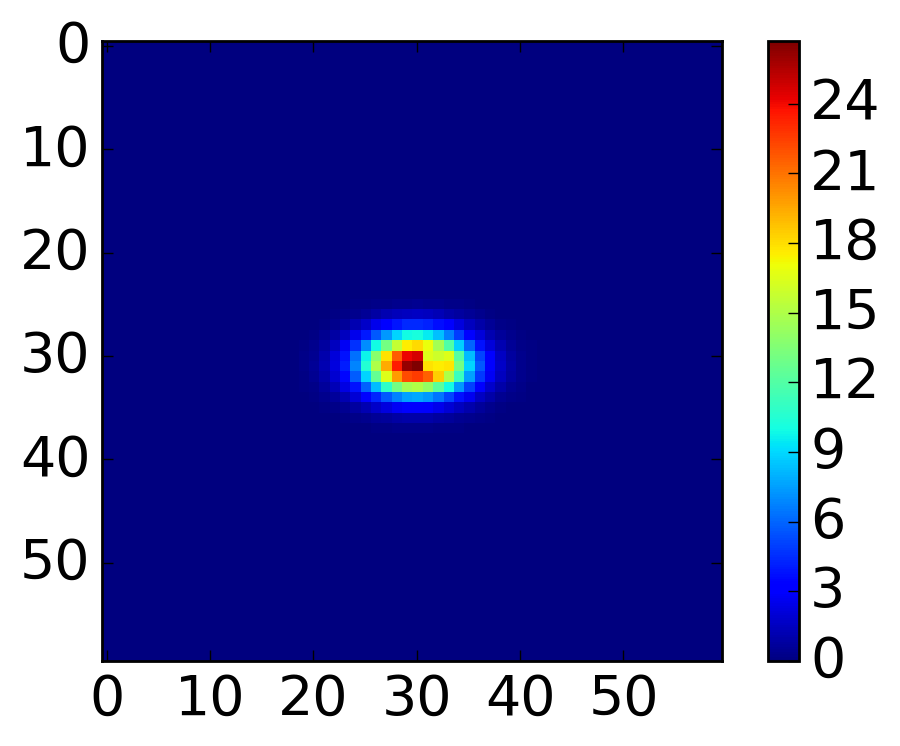

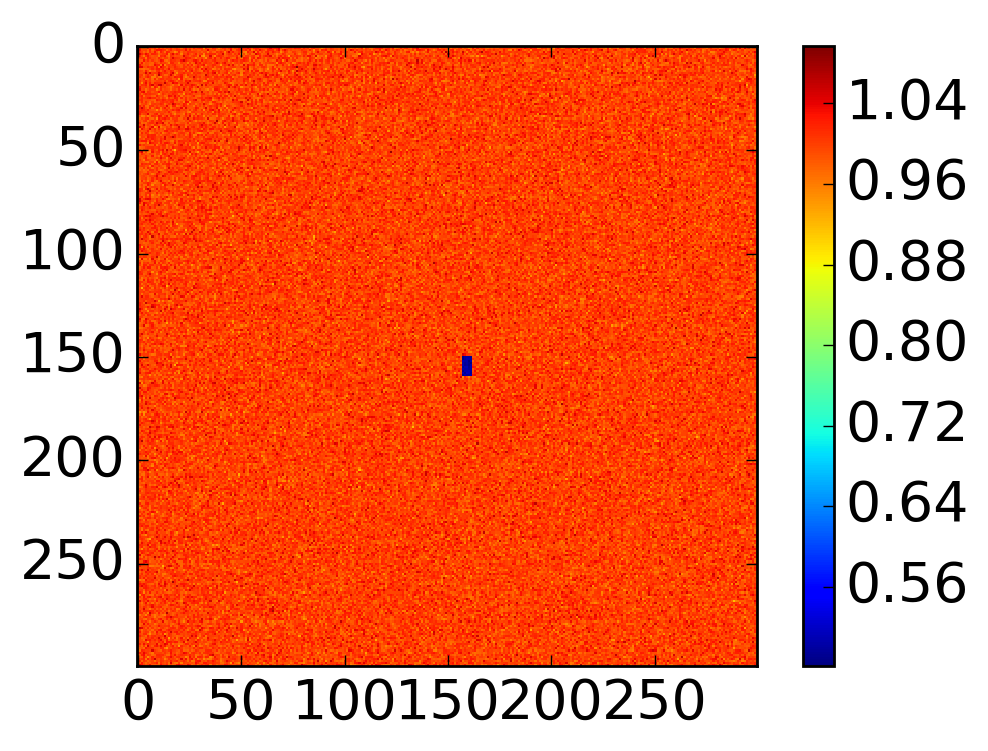

In [8]:
plt.imshow(Z[61], interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(Resp, interpolation='nearest')
plt.colorbar()
plt.show()

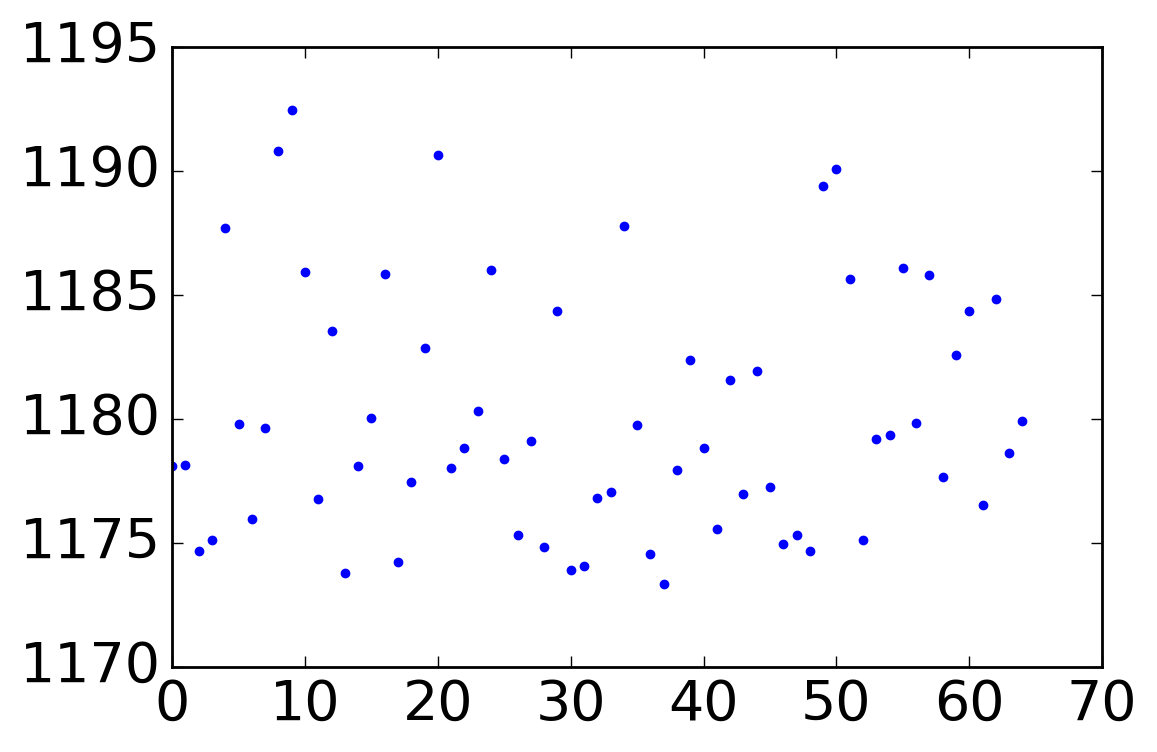

In [9]:
plt.plot(np.sum(Z, axis=(1,2)), '.')

In [10]:
z_tensor = tf.placeholder(tf.float64, (nframes,N,N))
z_err = tf.placeholder(tf.float64, (nframes,N,N))

In [11]:
from scipy import ndimage

In [12]:
x_cm_list = np.zeros((nframes,2))
for i in range(nframes):
    x_cm = ndimage.measurements.center_of_mass(Z[i])
    x_cm_list[i] = x_cm - np.array([12.6, 18.6])


In [13]:
def p_operator_orig(image, xshift, yshift, pad, flat):

        if np.abs(xshift) < 1e-8:
            if np.abs(yshift) < 1e-8:
                return image
        pss = int(pad*ss)
        lx, ly = Zmod.shape[0], Zmod.shape[1]
        xshift_model = xshift*ss
        yshift_model = yshift*ss
        whole_x = np.int(xshift_model)
        frac_x = np.mod(xshift_model, 1)
        whole_y = np.int(yshift_model)
        frac_y = np.mod(yshift_model, 1)


        ur = frac_x*frac_y
        ul = (1-frac_x)*(frac_y)
        lr = frac_x*(1-frac_y)
        ll = (1-frac_x)*(1-frac_y)



        output = np.zeros_like(Z[0])

        if pss+whole_x < 0:
            return output
        if pss + whole_x + lx >= len(output[:,0])*ss:
            return output
        if pss + whole_y < 0:
            return output
        if pss + whole_y + ly >= len(output[0])*ss:
            return output
        
        print(pss, whole_x, M, pss, lx, whole_x)

        paddings = [[pss +whole_x, M-pss-lx-whole_x], [pss +whole_y, M-pss-whole_y-ly]]
        output = np.pad(ll*image, paddings, 'constant')
        paddings = [[pss +whole_x+1, M-pss-lx-whole_x-1], [pss +whole_y, M-pss-whole_y-ly]]
        output += np.pad(lr*image, paddings, 'constant')
        paddings = [[pss +whole_x, M-pss-lx-whole_x], [pss +whole_y+1, M-pss-whole_y-ly-1]]
        output += np.pad(ul*image, paddings, 'constant')
        paddings = [[pss +whole_x+1, M-pss-lx-whole_x-1], [pss +whole_y+1, M-pss-whole_y-ly-1]]
        output += np.pad(ur*image, paddings, 'constant')
        
        output_flat = output * flat
        
        tmp = np.reshape(output_flat, (N, ss, N, ss))
        output = np.nansum(tmp, axis=(1, 3))

        return output

In [14]:
Zmod = 0.5*(1/(2*np.pi*sigma_x*sigma_y) * np.exp(-((Xmod+0.1)**2/(2*sigma_x**2)
     + (Ymod-0.9)**2/(2*sigma_y**2))))[140:240, 60:230]

10 82 300 10 100 82


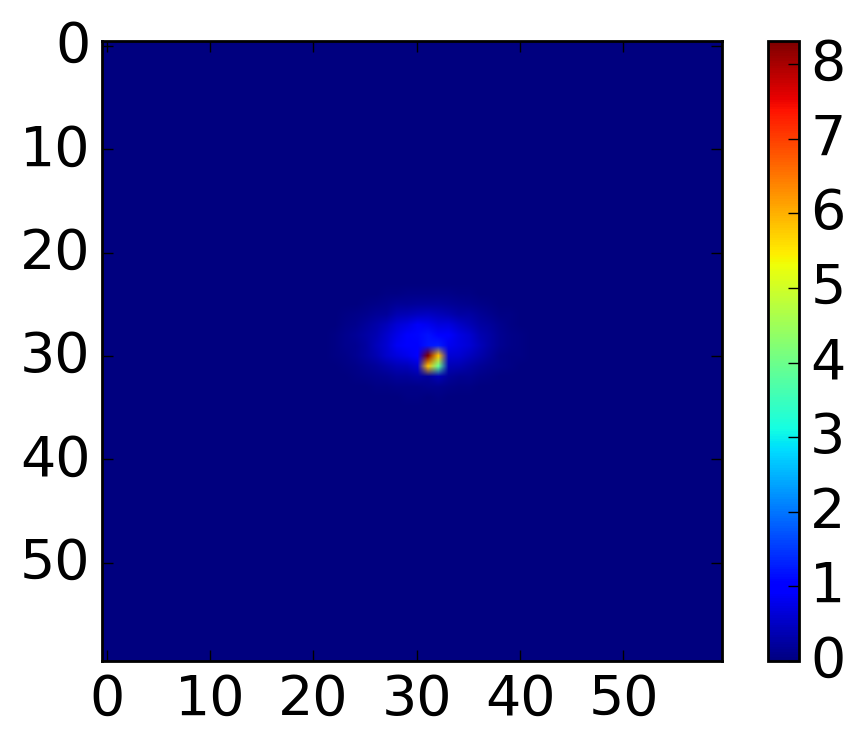

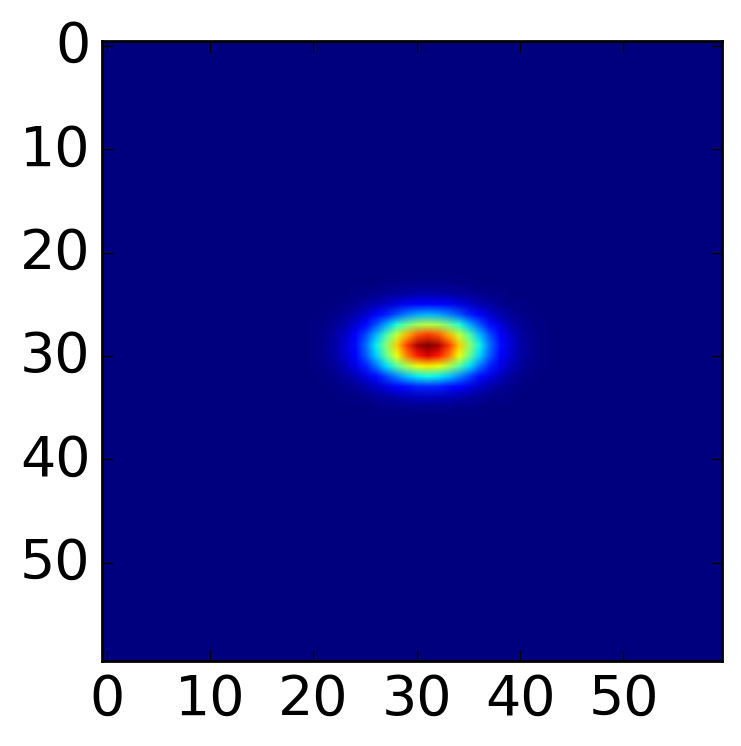

In [15]:
model = 1.0*p_operator_orig(Zmod, x_cm_list[1,0], x_cm_list[1,1], 2, np.ones((M,M)))

plt.imshow(model-Z[1])
plt.colorbar()
plt.show()

plt.imshow(model)

In [16]:
p0 = np.loadtxt('data/pos_curr.txt')
p1 = np.loadtxt('data/flux_curr.txt')
p2 = np.loadtxt('data/model_curr.txt')
p3 = np.loadtxt('data/flat_curr.txt')

pos = tf.Variable(p0*tf.ones((nframes, 2), dtype=tf.float64))
amp = tf.Variable(p1*tf.ones(nframes, dtype=tf.float64))
z_mod = tf.Variable(p2*tf.ones((Zmod.shape[0],Zmod.shape[1]), dtype=tf.float64))
flat = tf.Variable(p3*tf.ones((M,M),dtype=tf.float64))


In [ ]:
pos = tf.Variable(0.01*tf.ones((nframes, 2), dtype=tf.float64))
mu = tf.Variable(20*tf.ones(nframes, dtype=tf.float64))
sigma = tf.Variable(tf.ones((2), dtype=tf.float64))



In [ ]:
#model = mu*(1/(2*np.pi*sigma[0]*sigma[1]) * tf.exp(-((X-pos[0])**2/(2*sigma[0]**2)
#     + (Y-pos[1])**2/(2*sigma[1]**2))))

In [ ]:
#nll = 0.5*tf.reduce_sum((tf.divide((z_tensor - model), z_err)**2))

In [ ]:
#gradient = tf.gradients(nll, [pos, mu, sigma])

#opt = tf.train.GradientDescentOptimizer(1e-6).minimize(nll, var_list=[pos, mu, sigma])

#hess = tf.hessians(nll, [pos, mu, sigma])

#init = tf.global_variables_initializer()

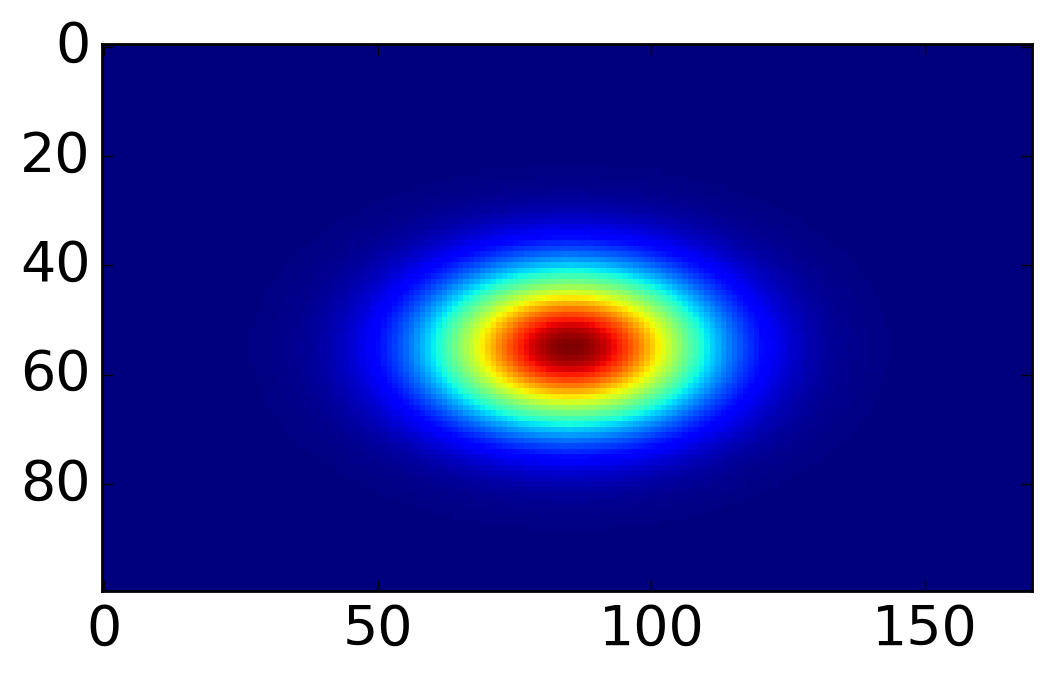

In [17]:
plt.imshow(Zmod, interpolation='nearest')

In [18]:
def p_operator(image, xshift, yshift, pad, flat):
        #print(tf.shape(image))


        pss = int(pad*ss)
        lx, ly = Zmod.shape[0], Zmod.shape[1]
        xshift_model = xshift*ss
        yshift_model = yshift*ss
        whole_x = tf.cast(xshift_model, tf.int32)
        frac_x = np.mod(xshift_model, 1)
        whole_y = tf.cast(yshift_model, tf.int32)
        frac_y = np.mod(yshift_model, 1)


        ur = frac_x*frac_y
        ul = (1-frac_x)*(frac_y)
        lr = frac_x*(1-frac_y)
        ll = (1-frac_x)*(1-frac_y)




        output = np.zeros_like(Zmod)
        '''
        if pss+whole_x < 0:
            return output
        if pss + whole_x + lx >= len(output[:,0]):
            return output
        if pss + whole_y < 0:
            return output
        if pss + whole_y + ly >= len(output[0]):
            return output
        '''
        #print(pss, whole_x, M, whole_y, ly)
        paddings = [[pss +whole_x, M-pss-lx-whole_x], [pss +whole_y, M-pss-whole_y-ly]]
        output = tf.pad(ll*image, paddings, 'constant')
        paddings = [[pss +whole_x+1, M-pss-lx-whole_x-1], [pss +whole_y, M-pss-whole_y-ly]]
        output += tf.pad(lr*image, paddings, 'constant')
        paddings = [[pss +whole_x, M-pss-lx-whole_x], [pss +whole_y+1, M-pss-whole_y-ly-1]]
        output += tf.pad(ul*image, paddings, 'constant')
        paddings = [[pss +whole_x+1, M-pss-lx-whole_x-1], [pss +whole_y+1, M-pss-whole_y-ly-1]]
        output += tf.pad(ur*image, paddings, 'constant')
        #output[pss + whole_x:pss + whole_x + lx, pss + whole_y:pss + whole_y + ly] += ll*image
        #output[pss + whole_x+1:pss + whole_x+1 + lx, pss + whole_y:pss + whole_y + ly] += lr*image
        #output[pss + whole_x:pss + whole_x + lx, pss + whole_y+1:pss + whole_y+1 + ly] += ul*image
        #output[pss + whole_x+1:pss + whole_x+1 + lx, pss + whole_y+1:pss + whole_y+1 + ly] += ur*image
        print(np.shape(image[:,0]))
        
        output_flat = tf.multiply(output, flat)
        
        tmp = tf.reshape(output_flat, (N, ss, N, ss))
        output = tf.reduce_sum(tmp, axis=(1, 3))

        return output

In [19]:
#amp = tf.Variable(0.9*tf.ones(nframes, dtype=tf.float64))
#z_mod = tf.Variable(Zmod*tf.ones((Zmod.shape[0],Zmod.shape[1]), dtype=tf.float64))
#flat = tf.Variable(tf.ones((M,M),dtype=tf.float64))
#pos = tf.Variable(x_cm_list*tf.ones((nframes,2), dtype=tf.float64))

z_test = [amp[i]*p_operator(z_mod, pos[i,0], pos[i,1], 2, flat) for i in range(nframes)]

Tensor("Shape:0", shape=(2,), dtype=int32)
10 Tensor("Cast:0", shape=(), dtype=int32) 300 Tensor("Cast_1:0", shape=(), dtype=int32) 170
(100,)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
10 Tensor("Cast_2:0", shape=(), dtype=int32) 300 Tensor("Cast_3:0", shape=(), dtype=int32) 170
(100,)
Tensor("Shape_2:0", shape=(2,), dtype=int32)
10 Tensor("Cast_4:0", shape=(), dtype=int32) 300 Tensor("Cast_5:0", shape=(), dtype=int32) 170
(100,)
Tensor("Shape_3:0", shape=(2,), dtype=int32)
10 Tensor("Cast_6:0", shape=(), dtype=int32) 300 Tensor("Cast_7:0", shape=(), dtype=int32) 170
(100,)
Tensor("Shape_4:0", shape=(2,), dtype=int32)
10 Tensor("Cast_8:0", shape=(), dtype=int32) 300 Tensor("Cast_9:0", shape=(), dtype=int32) 170
(100,)
Tensor("Shape_5:0", shape=(2,), dtype=int32)
10 Tensor("Cast_10:0", shape=(), dtype=int32) 300 Tensor("Cast_11:0", shape=(), dtype=int32) 170
(100,)
Tensor("Shape_6:0", shape=(2,), dtype=int32)
10 Tensor("Cast_12:0", shape=(), dtype=int32) 300 Tensor("Cast_13:0", shape

In [ ]:
nll = 0.5*tf.reduce_sum((tf.divide((z_tensor - z_test), z_err)**2))
gradient = tf.gradients(nll, [pos, amp, z_mod])
#opt = tf.train.GradientDescentOptimizer(1e-14).minimize(nll, var_list=[pos, amp, z_mod, flat])
opt = tf.train.AdagradOptimizer(0.05).minimize(nll, var_list=[pos, amp, z_mod, flat])
hess = tf.hessians(nll, [pos, amp, z_mod, flat])
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as session:
    session.run(init)
    
    data = {z_tensor: Z, z_err: Zerr}
    nll_history = []
    for i in range(10000):
        session.run(opt, feed_dict=data)
        nll_history.append(session.run(nll, feed_dict=data))
        print(nll_history[-1])

In [ ]:
def print_loss(loss_evaled, vector_evaled):
    print(loss_evaled, vector_evaled)

In [20]:
nll = 0.5*tf.reduce_sum((tf.divide((z_tensor - z_test), z_err)**2))


optim = tf.contrib.opt.ScipyOptimizerInterface(loss=nll,
                                                   method='L-BFGS-B', options={'maxiter': 12000})

nll_history = []

data = {z_tensor: Z, z_err: Zerr}

with tf.Session() as sess:
    # initialize
    sess.run(fetches=tf.global_variables_initializer())

    for i in range(10):
        # gradient step
        optim.minimize(session=sess, feed_dict=data)
        # sess.run(fetches=train_op, feed_dict={x: x_obs})
        
        #optim.minimize(session=sess, feed_dict=data, loss_callback=print_loss, fetches=[nll, vector])
        
        #print(vector.eval())

        # update loss
        nll_history.append(sess.run(fetches=nll, feed_dict=data))
        
        params = sess.run([pos, amp, z_mod, flat])
        
        np.savetxt('data/pos_curr.txt', params[0])
        np.savetxt('data/flux_curr.txt', params[1])
        np.savetxt('data/model_curr.txt', params[2])
        np.savetxt('data/flat_curr.txt', params[3])
        
        if i > 2:
            if nll_history[-1]*1.001 > nll_history[-2]:
                break

    params = sess.run([pos, amp, z_mod, flat])
    #pred = sess.run(model, feed_dict=data)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 50465.568268
  Number of iterations: 12001
  Number of functions evaluations: 12406
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 50195.239259
  Number of iterations: 12001
  Number of functions evaluations: 12393
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 49950.685491
  Number of iterations: 12001
  Number of functions evaluations: 12400
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 49774.769403
  Number of iterations: 12001
  Number of functions evaluations: 12448
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 4953

In [21]:
np.savetxt('data/pos_curr.txt', params[0])
np.savetxt('data/flux_curr.txt', params[1])
np.savetxt('data/model_curr.txt', params[2])
np.savetxt('data/flat_curr.txt', params[3])

10 85 300 10 100 85


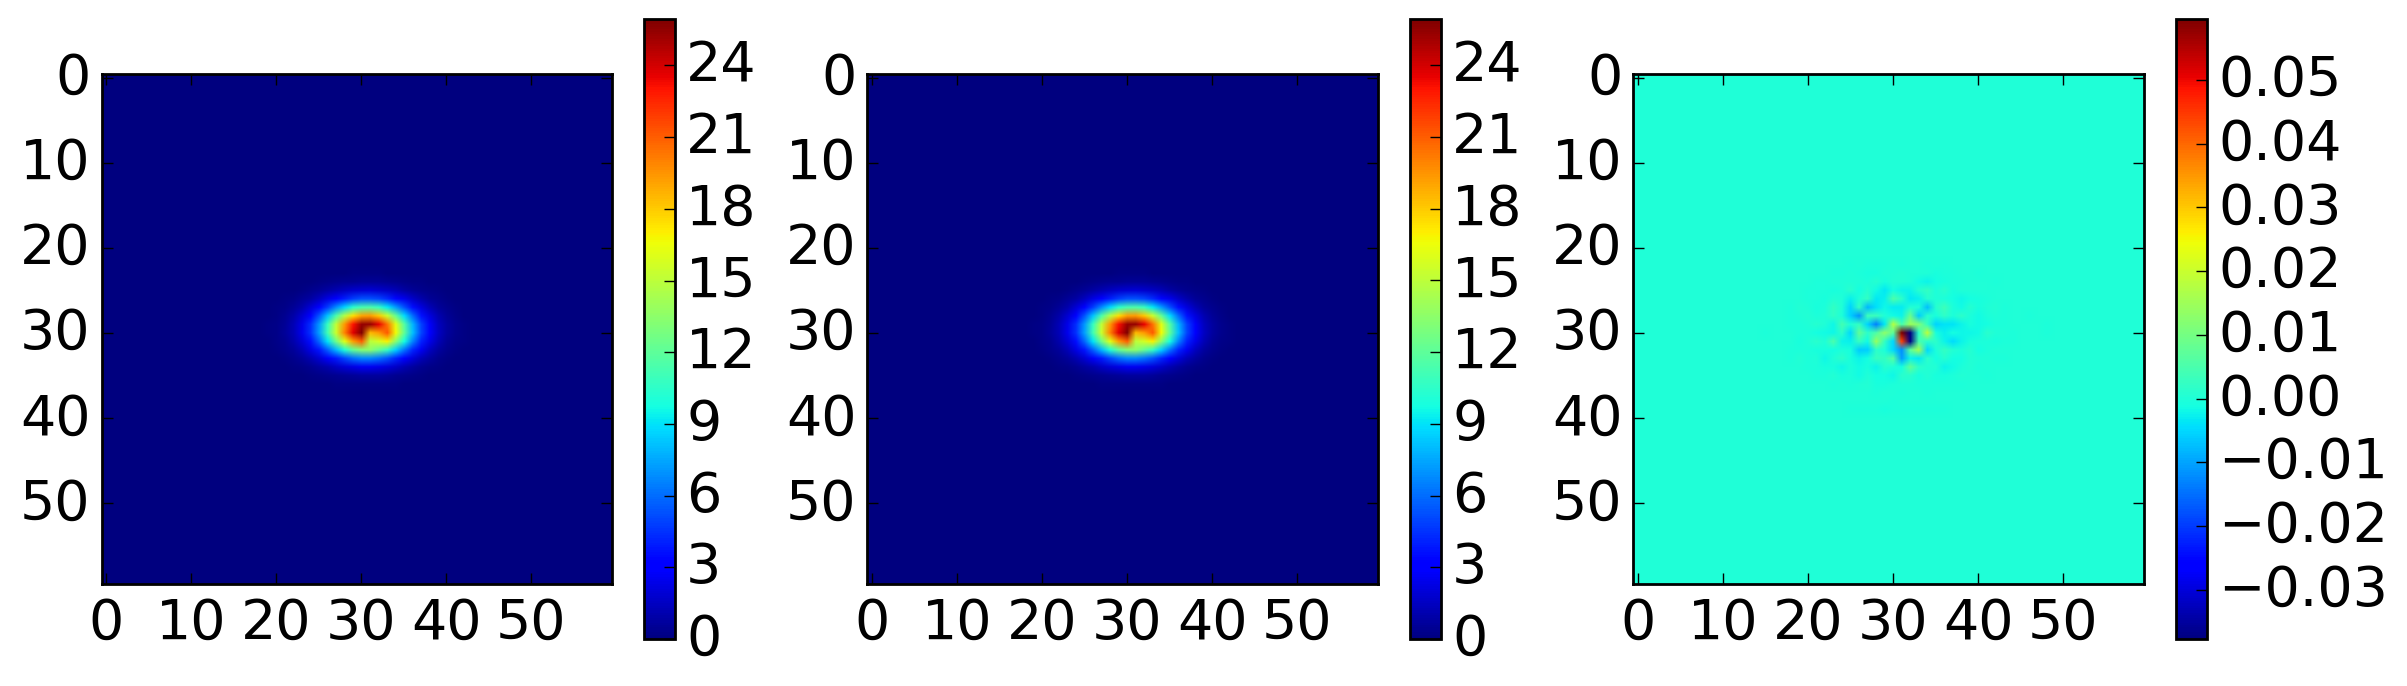

In [22]:
j = 6
model = params[1][j]*p_operator_orig(params[2], params[0][j][0], params[0][j][1], 2, params[3])
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.imshow(model)
plt.colorbar()
plt.subplot(132)
plt.imshow(Z[j])
plt.colorbar()
plt.subplot(133)
plt.imshow(model-Z[j])
plt.colorbar()
plt.show()

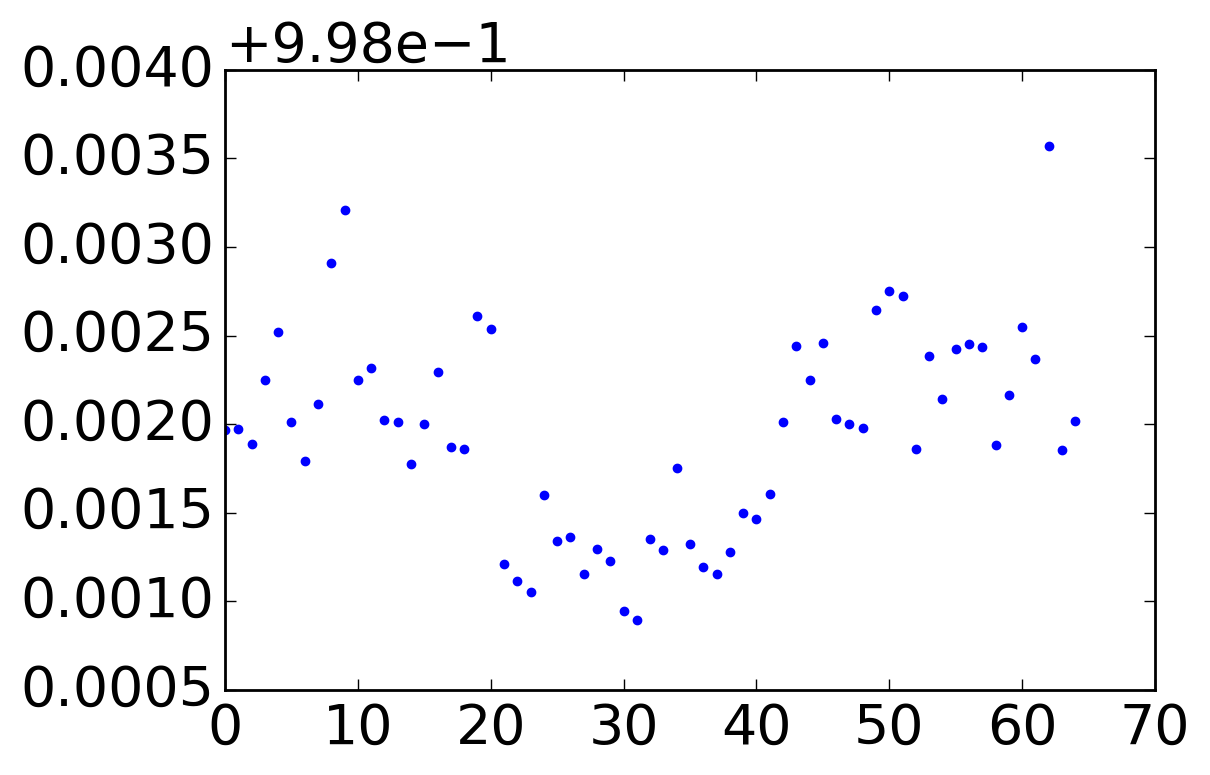

In [23]:
plt.plot(params[1]/np.median(params[1]), '.')

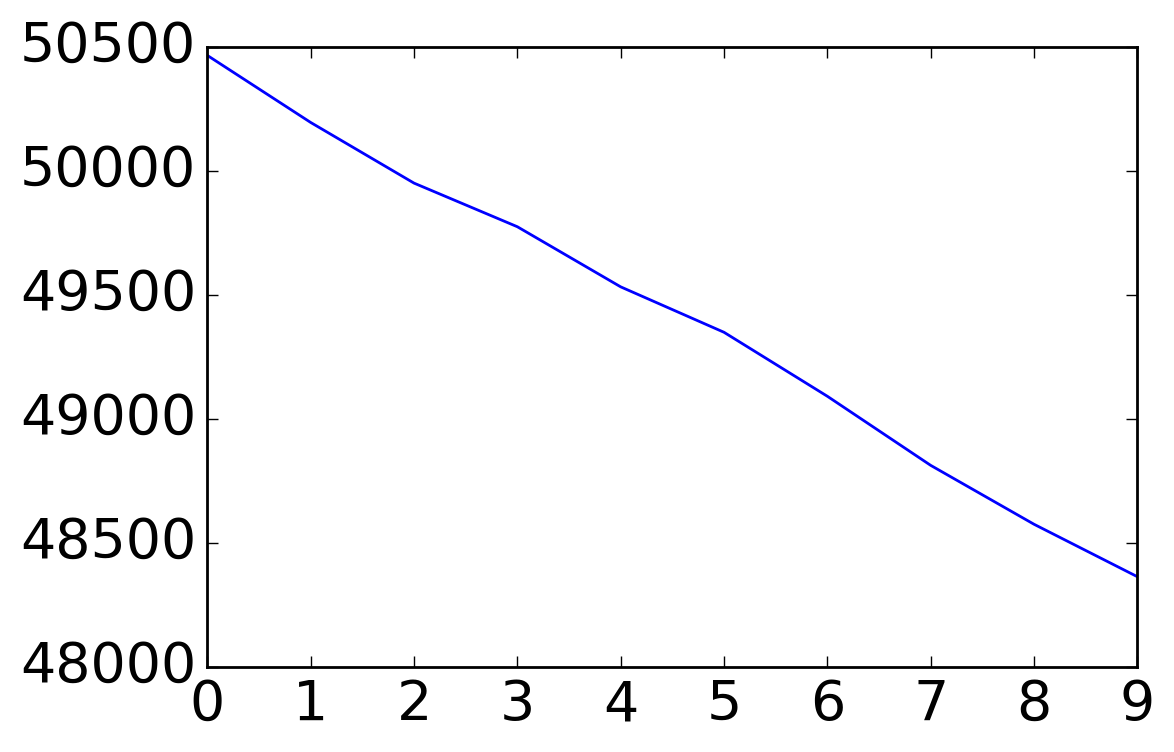

In [24]:
plt.plot(nll_history)

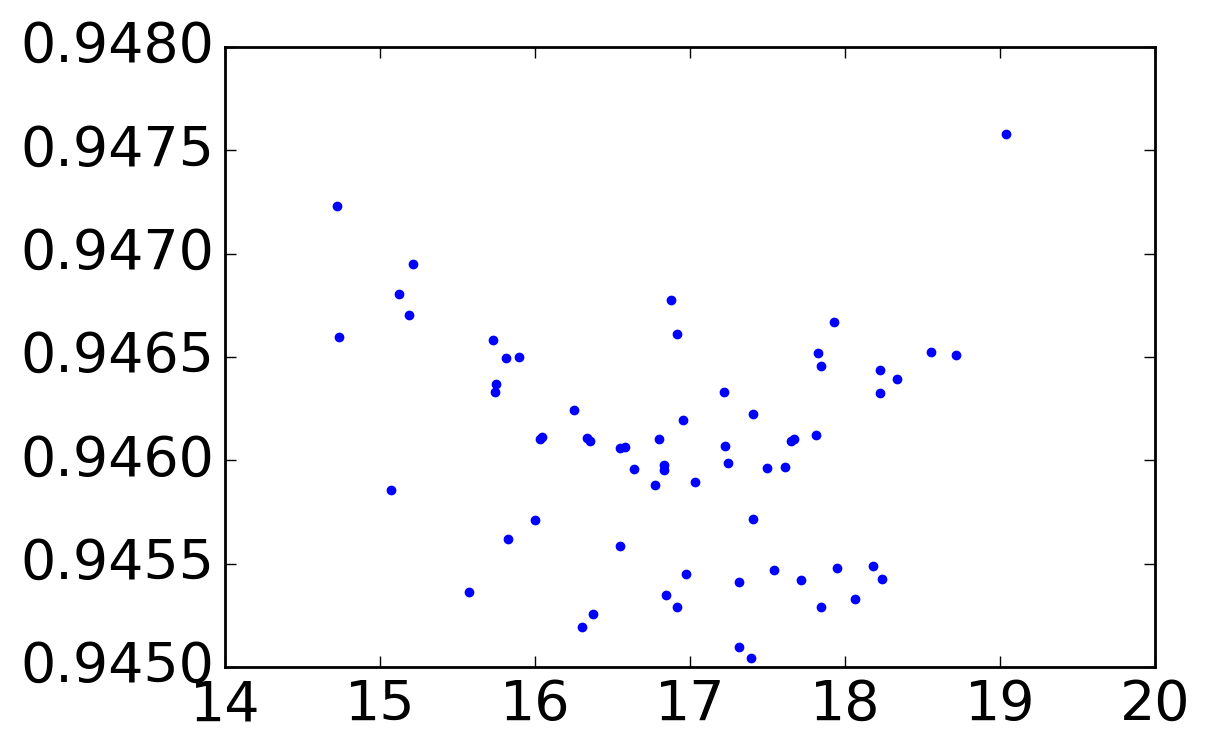

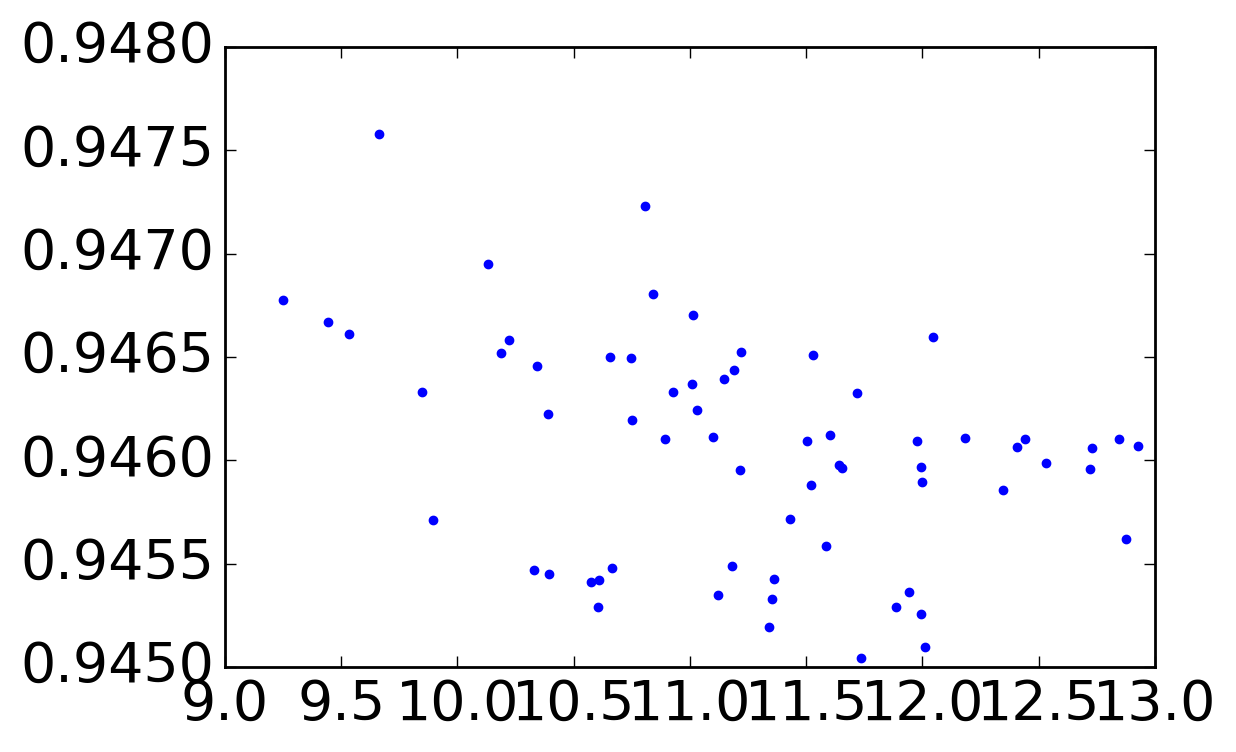

In [25]:
plt.plot(params[0][:,0], params[1], '.')
plt.show()
plt.plot(params[0][:,1], params[1], '.')
plt.show()

In [ ]:
yerr = np.sum(np.sqrt((0.05*Zerr[0])**2))/np.sum(Z[0])
print(yerr)
plt.errorbar(np.arange(65), params[1]/np.median(params[1]), yerr=yerr, fmt='k.')


In [26]:
params[0]

array([[16.54926186, 12.72718777],
       [16.57992874, 12.40473422],
       [17.24512255, 12.5325132 ],
       [18.22488898, 11.71660496],
       [15.73146748, 10.22079391],
       [16.80258885, 10.89184852],
       [17.03477791, 11.99973155],
       [16.9560764 , 10.74875105],
       [15.21471751, 10.13000109],
       [14.72289183, 10.80497321],
       [15.74462556, 10.92745769],
       [18.33451633, 11.14427434],
       [16.04425569, 11.09736697],
       [17.66802333, 12.44069987],
       [16.7744756 , 11.51897161],
       [16.35407879, 11.97534516],
       [15.74691071, 11.00783811],
       [17.61427861, 11.99224461],
       [16.63935758, 12.71864865],
       [17.93003355,  9.44385452],
       [14.7347191 , 12.04705202],
       [16.84406871, 11.12258969],
       [16.37658228, 11.99328208],
       [16.30487315, 11.34003383],
       [16.00103381,  9.8963655 ],
       [17.54027965, 10.32792209],
       [18.17859771, 11.18280828],
       [16.91917415, 10.60474823],
       [18.23788922,

In [ ]:
model = 1.0*p_operator_orig(Zmod, 20.0, 15.0, 2)
plt.imshow(model)

In [27]:
np.std(params[1]/np.median(params[1]))

0.0005638976064374746

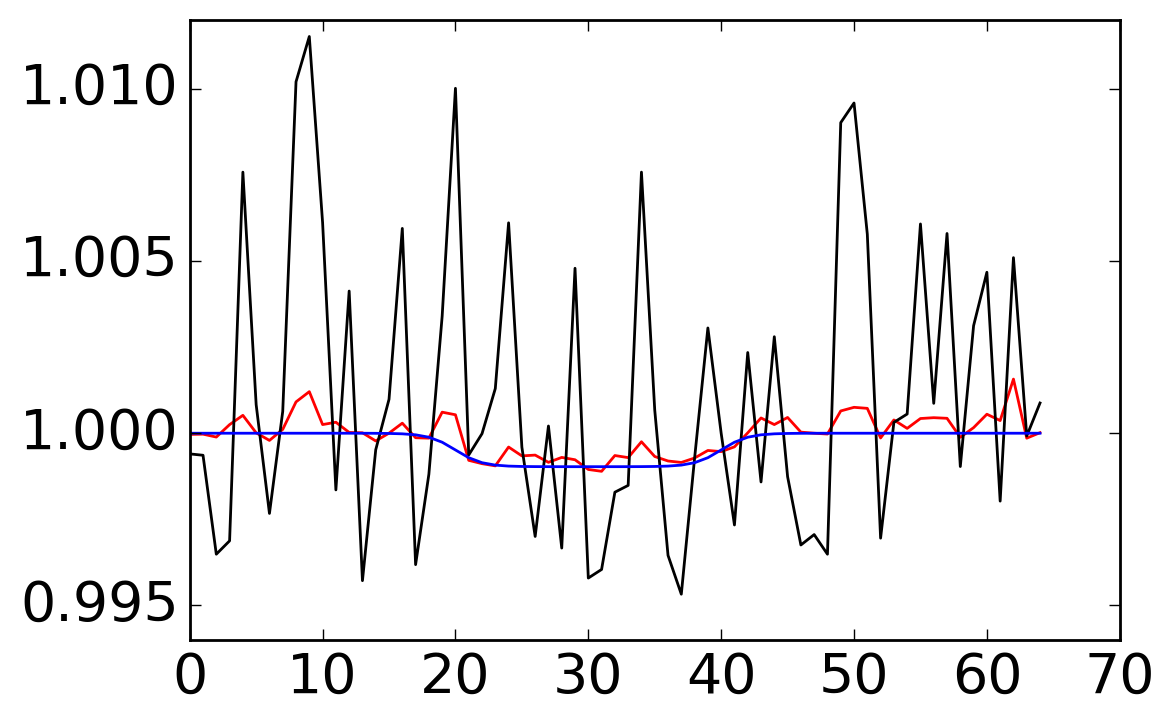

In [28]:
pl1 = params[1]/np.median(params[1])
pl2 = np.sum(Z_first, axis=(1,2))/np.median(np.sum(Z_first, axis=(1,2)))
plt.plot(pl1, 'r') 
plt.plot(pl2, 'k')
plt.plot(fluxval, 'b')

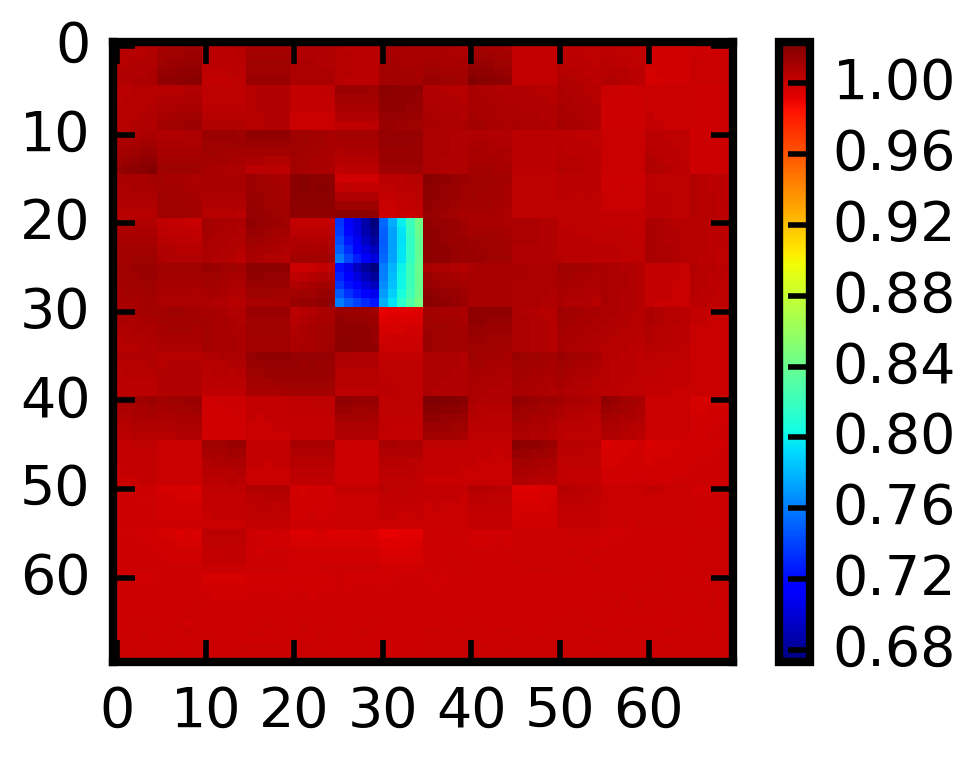

In [78]:
plt.imshow(params[3][130:200,130:200], interpolation='nearest')
plt.colorbar()

In [43]:
print(np.std(pl1[45:60])/np.sqrt(13)*1e6)
print(np.std(pl2[45:60])/np.sqrt(13)*1e6)

80.61766452547342
1210.6696579044658


In [ ]:
np.savetxt('data/pos_curr.txt', params[0])
np.savetxt('data/flux_curr.txt', params[1])
np.savetxt('data/model_curr.txt', params[2])
np.savetxt('data/flat_curr.txt', params[3])

In [51]:
plt.rcParams['axes.linewidth']=3
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rc('xtick.major', size=8, pad=8)
plt.rc('xtick.minor', size=6, pad=5)
plt.rc('ytick.major', size=8, pad=8)
plt.rc('ytick.minor', size=6, pad=5)

plt.gcf().subplots_adjust(left=0.17, bottom=0.17, right=0.97, top=0.94, wspace=0.0, hspace=0.0)


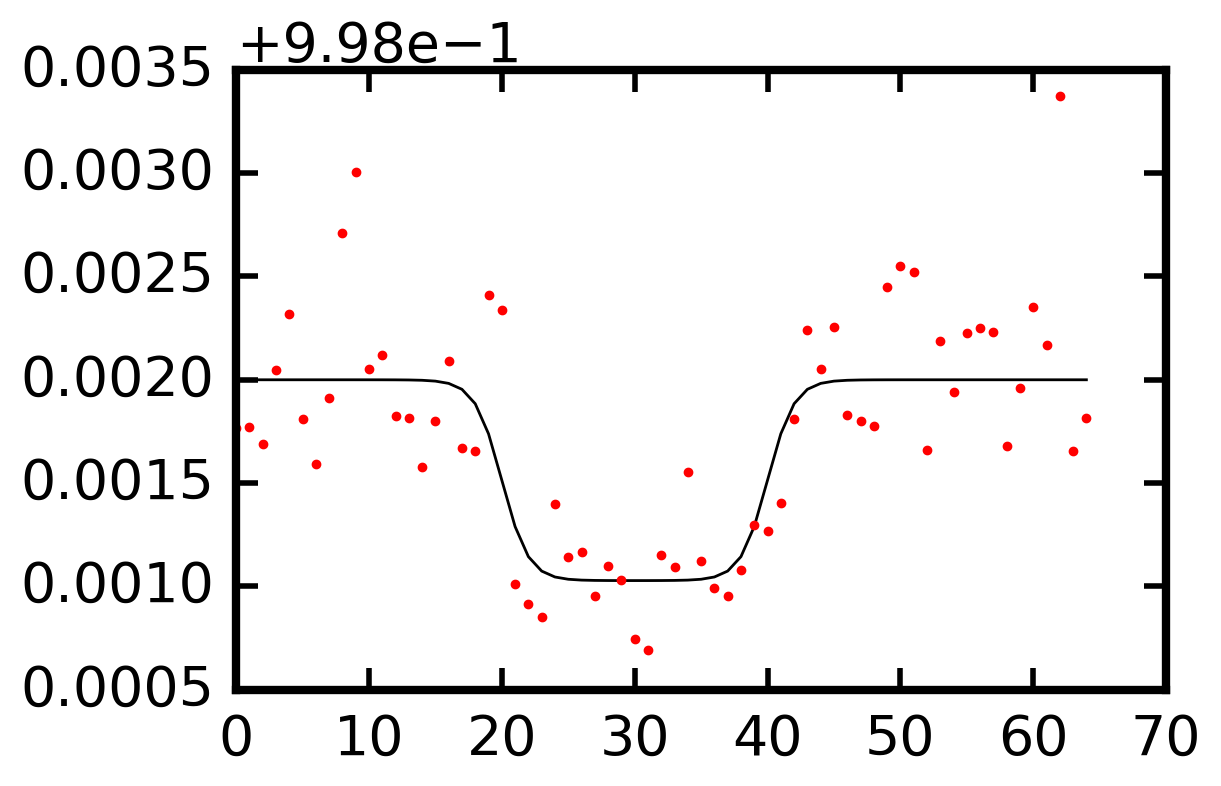

In [52]:
plt.plot(fluxval, 'k')
plt.plot(pl1-0.0002, 'r.')

In [74]:
#plt.plot(np.arange(len(pl2))*0.0204, fluxval, 'k')
plt.clf()
plt.gcf().subplots_adjust(left=0.23, bottom=0.17, right=0.97, top=0.94, wspace=0.0, hspace=0.0)
plt.plot(np.arange(len(pl2))*0.0204, pl2-0.0025, 'r.')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Relative Flux', fontsize=20)
plt.xlabel('Time (days)', fontsize=20)
plt.ylim(0.992, 1.01)
plt.savefig('f1.png', transparent=True)
plt.clf()
plt.plot(np.arange(len(pl2))*0.0204, pl1-0.0002, 'r.')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Relative Flux', fontsize=20)
plt.xlabel('Time (days)', fontsize=20)
plt.ylim(0.992, 1.01)
plt.savefig('f2.png', transparent=True)
plt.clf()
plt.plot(np.arange(len(pl2))*0.0204, pl1-0.0002, 'r.')
plt.xticks(fontsize=16)
plt.yticks([0.999, 1.000, 1.001, 1.002], ['0.999', '1.000', '1.001', '1.002'], fontsize=16)
plt.ylabel('Relative Flux', fontsize=20)
plt.xlabel('Time (days)', fontsize=20)
plt.savefig('f3.png', transparent=True)
plt.clf()
plt.plot(np.arange(len(pl2))*0.0204, pl1-0.0002, 'r.')
plt.plot(np.arange(len(pl2))*0.0204, fluxval, 'k')
plt.xticks(fontsize=16)
plt.yticks([0.999, 1.000, 1.001, 1.002], ['0.999', '1.000', '1.001', '1.002'], fontsize=16)
plt.ylabel('Relative Flux', fontsize=20)
plt.xlabel('Time (days)', fontsize=20)
plt.savefig('f4.png', transparent=True)
plt.clf()

In [40]:
pl2

array([0.99939997, 0.99936006, 0.9964877 , 0.9968756 , 1.00757989,
       1.00082861, 0.99767141, 1.00063415, 1.01020371, 1.0115178 ,
       1.00611751, 0.99835427, 1.00412752, 0.99571961, 0.99952093,
       1.00098515, 1.00594606, 0.99618495, 0.99881034, 1.00339802,
       1.01001369, 0.99936886, 0.99998681, 1.00129733, 1.00610811,
       0.999595  , 0.99700307, 1.00020948, 0.99666585, 1.00478907,
       0.99579503, 0.99604478, 0.99828794, 0.99848536, 1.00758032,
       1.00067327, 0.99645412, 0.99532675, 0.99927426, 1.00305599,
       1.        , 0.9973362 , 1.00234301, 0.99858501, 1.00280161,
       0.99873837, 0.99675539, 0.99705728, 0.99648811, 1.00901661,
       1.00958732, 1.00577946, 0.9969537 , 1.00031426, 1.00055734,
       1.00607541, 1.00086753, 1.00579853, 0.99903283, 1.00312028,
       1.00467303, 0.99802896, 1.0050973 , 0.99991867, 1.00087759])

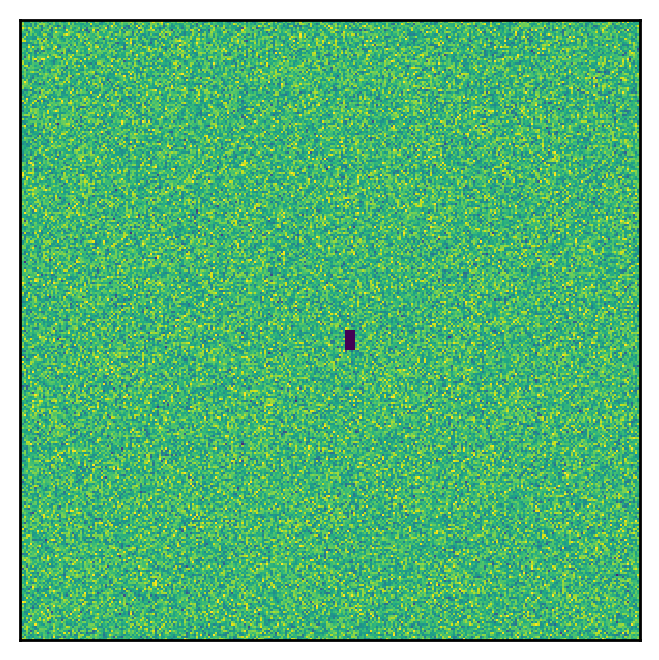

In [49]:
plt.imshow(Resp, interpolation='nearest', vmax=1.05, vmin=0.9, cmap='viridis')
#plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.show()

test
